In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.chdir("/content/sample2/")

FileNotFoundError: ignored

In [0]:
def get_generator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  
  hid = Dense(128 * 16 * 16, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((16, 16, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [0]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''

  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation("relu")(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation("relu")(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation("relu")(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = Activation("relu")(hid)

  hid = Flatten()(hid)
  hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(input_layer, out)

  model.summary()

  return model, out

In [0]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()

In [7]:
# GAN creation
img_input = Input(shape=(32,32,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       

In [8]:
BATCH_SIZE = 16

# # Get training images
(X_train, y_train), (X_test, _) = cifar10.load_data()

# Select Cars
X_train = X_train[y_train[:,0]==1]
print ("Training shape: {}".format(X_train.shape))

# Normalize data
X_train = (X_train - 127.5) / 127.5
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

170500096/170498071 [==============================] - 2s 0us/step
Training shape: (5000, 32, 32, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  Epoch: 1, Generator Loss: 1.5320543872001462, Discriminator Loss: [0.32990667 0.        ]


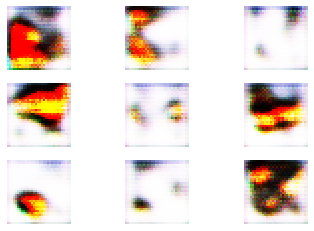

  Epoch: 2, Generator Loss: 1.2261578739644625, Discriminator Loss: [0.32963836 0.        ]
  Epoch: 3, Generator Loss: 1.57755321276207, Discriminator Loss: [0.39615992 0.        ]
  Epoch: 4, Generator Loss: 1.3483618460953808, Discriminator Loss: [0.37662852 0.        ]
  Epoch: 5, Generator Loss: 1.566054515242099, Discriminator Loss: [0.33867484 0.        ]
  Epoch: 6, Generator Loss: 1.5376765332542932, Discriminator Loss: [0.37334248 0.        ]
  Epoch: 7, Generator Loss: 1.43338848112557, Discriminator Loss: [0.4301696 0.       ]
  Epoch: 8, Generator Loss: 1.4851340437069154, Discriminator Loss: [0.40590158 0.        ]
  Epoch: 9, Generator Loss: 1.5400676569805887, Discriminator Loss: [0.42619753 0.        ]
  Epoch: 10, Generator Loss: 1.6649192063949811, Discriminator Loss: [0.45019487 0.        ]
  Epoch: 11, Generator Loss: 1.4883589931309988, Discriminator Loss: [0.49516398 0.        ]


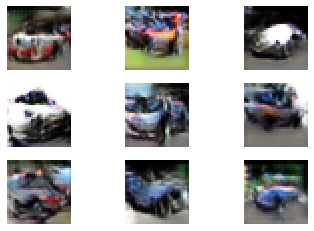

  Epoch: 12, Generator Loss: 1.2642905215422313, Discriminator Loss: [0.48895636 0.        ]
  Epoch: 13, Generator Loss: 1.3629234772748673, Discriminator Loss: [0.451399 0.      ]
  Epoch: 14, Generator Loss: 1.396566021375549, Discriminator Loss: [0.49172044 0.        ]
  Epoch: 15, Generator Loss: 1.4065288326774652, Discriminator Loss: [0.43435273 0.        ]
  Epoch: 16, Generator Loss: 1.5403781507212, Discriminator Loss: [0.46948084 0.        ]
  Epoch: 17, Generator Loss: 1.417909977145684, Discriminator Loss: [0.48588014 0.        ]
  Epoch: 18, Generator Loss: 1.4229487660221565, Discriminator Loss: [0.4825769 0.       ]
  Epoch: 19, Generator Loss: 1.4405750998128684, Discriminator Loss: [0.4898989 0.       ]
  Epoch: 20, Generator Loss: 1.3969593642709346, Discriminator Loss: [0.47588545 0.        ]
  Epoch: 21, Generator Loss: 1.331729877835665, Discriminator Loss: [0.51254725 0.        ]


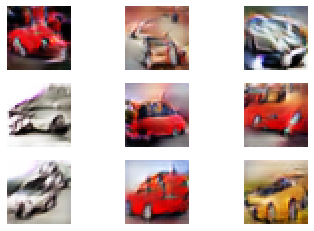

  Epoch: 22, Generator Loss: 1.2904395351234155, Discriminator Loss: [0.5205352 0.       ]
  Epoch: 23, Generator Loss: 1.323231325413172, Discriminator Loss: [0.5267203 0.       ]
  Epoch: 24, Generator Loss: 1.3378227331126347, Discriminator Loss: [0.48103026 0.        ]
  Epoch: 25, Generator Loss: 1.3835435445683124, Discriminator Loss: [0.46393225 0.        ]
  Epoch: 26, Generator Loss: 1.2550880771894486, Discriminator Loss: [0.47151527 0.        ]
  Epoch: 27, Generator Loss: 1.428200368506786, Discriminator Loss: [0.4891371 0.       ]
  Epoch: 28, Generator Loss: 1.3959025996617782, Discriminator Loss: [0.47311372 0.        ]
  Epoch: 29, Generator Loss: 1.4993022170204382, Discriminator Loss: [0.46639124 0.        ]
  Epoch: 30, Generator Loss: 1.6477678000735931, Discriminator Loss: [0.44159052 0.        ]
  Epoch: 31, Generator Loss: 1.799320974220068, Discriminator Loss: [0.44380194 0.        ]


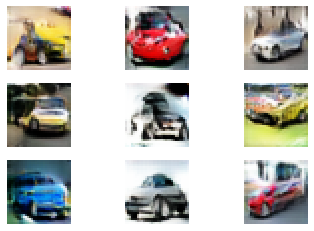

  Epoch: 32, Generator Loss: 1.7152779151518376, Discriminator Loss: [0.39041615 0.        ]
  Epoch: 33, Generator Loss: 1.920263486603896, Discriminator Loss: [0.39448583 0.        ]
  Epoch: 34, Generator Loss: 1.8448239501852255, Discriminator Loss: [0.43870842 0.        ]
  Epoch: 35, Generator Loss: 1.7166136517547643, Discriminator Loss: [0.44331345 0.        ]
  Epoch: 36, Generator Loss: 1.860935929685067, Discriminator Loss: [0.4309745 0.       ]
  Epoch: 37, Generator Loss: 1.8585610433648794, Discriminator Loss: [0.41131172 0.        ]
  Epoch: 38, Generator Loss: 1.8259635399549434, Discriminator Loss: [0.38110793 0.        ]
  Epoch: 39, Generator Loss: 1.8939767638460183, Discriminator Loss: [0.4024838 0.       ]
  Epoch: 40, Generator Loss: 1.9863366641295261, Discriminator Loss: [0.3937406 0.       ]
  Epoch: 41, Generator Loss: 2.019756256387784, Discriminator Loss: [0.3860424 0.       ]


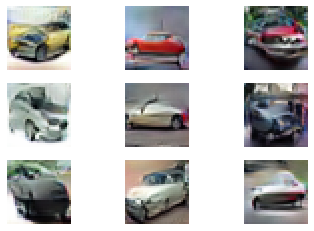

  Epoch: 42, Generator Loss: 2.086136768070551, Discriminator Loss: [0.36956203 0.        ]
  Epoch: 43, Generator Loss: 2.1548189788292618, Discriminator Loss: [0.3690541 0.       ]
  Epoch: 44, Generator Loss: 2.141424883825657, Discriminator Loss: [0.36581475 0.        ]
  Epoch: 45, Generator Loss: 2.3079229413698883, Discriminator Loss: [0.36311352 0.        ]
  Epoch: 46, Generator Loss: 2.3000571278807445, Discriminator Loss: [0.34370503 0.        ]
  Epoch: 47, Generator Loss: 2.4174629094508977, Discriminator Loss: [0.3533323 0.       ]
  Epoch: 48, Generator Loss: 2.4721453761061034, Discriminator Loss: [0.34771523 0.        ]
  Epoch: 49, Generator Loss: 2.4381397305390773, Discriminator Loss: [0.342746 0.      ]
  Epoch: 50, Generator Loss: 2.413631270138117, Discriminator Loss: [0.3404184 0.       ]
  Epoch: 51, Generator Loss: 2.4881256003028307, Discriminator Loss: [0.3430654 0.       ]


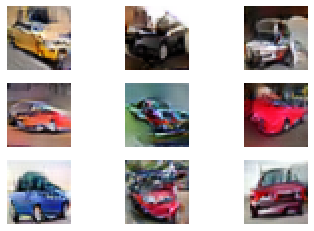

  Epoch: 52, Generator Loss: 2.5519746037629933, Discriminator Loss: [0.33482042 0.        ]
  Epoch: 53, Generator Loss: 2.5985057896528487, Discriminator Loss: [0.31772986 0.        ]
  Epoch: 54, Generator Loss: 2.6625477402256084, Discriminator Loss: [0.31406382 0.        ]
  Epoch: 55, Generator Loss: 2.6756124068529177, Discriminator Loss: [0.31710312 0.        ]
  Epoch: 56, Generator Loss: 2.781670793508872, Discriminator Loss: [0.31973678 0.        ]
  Epoch: 57, Generator Loss: 2.7222450581880717, Discriminator Loss: [0.30821848 0.        ]
  Epoch: 58, Generator Loss: 2.770746282660044, Discriminator Loss: [0.31149018 0.        ]
  Epoch: 59, Generator Loss: 2.801346403283951, Discriminator Loss: [0.30994996 0.        ]
  Epoch: 60, Generator Loss: 2.8079158866252656, Discriminator Loss: [0.3061864 0.       ]
  Epoch: 61, Generator Loss: 2.867822419756498, Discriminator Loss: [0.3037271 0.       ]


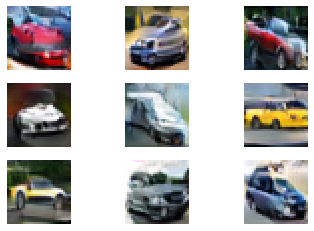

  Epoch: 62, Generator Loss: 2.900890493240112, Discriminator Loss: [0.30295265 0.        ]
  Epoch: 63, Generator Loss: 2.829435042081735, Discriminator Loss: [0.2961876 0.       ]
  Epoch: 64, Generator Loss: 2.857812516200237, Discriminator Loss: [0.30251208 0.        ]
  Epoch: 65, Generator Loss: 2.8786573257201757, Discriminator Loss: [0.2920404 0.       ]
  Epoch: 66, Generator Loss: 2.8906377920737634, Discriminator Loss: [0.29251763 0.        ]
  Epoch: 67, Generator Loss: 2.9801468478563504, Discriminator Loss: [0.29107878 0.        ]
  Epoch: 68, Generator Loss: 2.997033510452662, Discriminator Loss: [0.28480253 0.        ]
  Epoch: 69, Generator Loss: 2.953321194801575, Discriminator Loss: [0.2796261 0.       ]
  Epoch: 70, Generator Loss: 2.9519303811666293, Discriminator Loss: [0.2816353 0.       ]
  Epoch: 71, Generator Loss: 3.0483935356904297, Discriminator Loss: [0.28994095 0.        ]


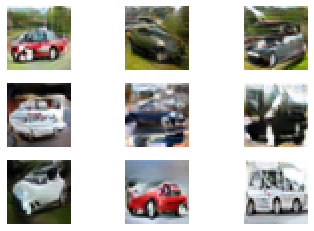

  Epoch: 72, Generator Loss: 3.044036301664817, Discriminator Loss: [0.27570486 0.        ]
  Epoch: 73, Generator Loss: 3.0182842998168407, Discriminator Loss: [0.27958393 0.        ]
  Epoch: 74, Generator Loss: 3.047585618801606, Discriminator Loss: [0.27437544 0.        ]
  Epoch: 75, Generator Loss: 3.0647997859960947, Discriminator Loss: [0.27906838 0.        ]
  Epoch: 76, Generator Loss: 3.043238822848369, Discriminator Loss: [0.2774975 0.       ]
  Epoch: 77, Generator Loss: 3.119432887587792, Discriminator Loss: [0.27205053 0.        ]
  Epoch: 78, Generator Loss: 3.0328860649695764, Discriminator Loss: [0.2757605 0.       ]
  Epoch: 79, Generator Loss: 3.096999562703646, Discriminator Loss: [0.268977 0.      ]
  Epoch: 80, Generator Loss: 3.0785749145807366, Discriminator Loss: [0.26806903 0.        ]
  Epoch: 81, Generator Loss: 3.1210115357087207, Discriminator Loss: [0.26456487 0.        ]


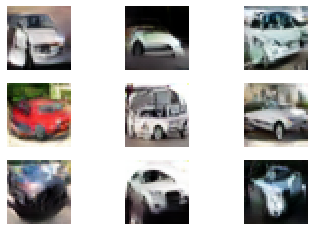

  Epoch: 82, Generator Loss: 3.139796956991538, Discriminator Loss: [0.26994905 0.        ]
  Epoch: 83, Generator Loss: 3.0277131646871567, Discriminator Loss: [0.26192456 0.        ]
  Epoch: 84, Generator Loss: 3.1182652677480993, Discriminator Loss: [0.2676623 0.       ]
  Epoch: 85, Generator Loss: 3.093339518476755, Discriminator Loss: [0.26191315 0.        ]
  Epoch: 86, Generator Loss: 3.141828029201581, Discriminator Loss: [0.25962913 0.        ]
  Epoch: 87, Generator Loss: 3.112319515301631, Discriminator Loss: [0.26253852 0.        ]
  Epoch: 88, Generator Loss: 3.1983659103130684, Discriminator Loss: [0.261106 0.      ]
  Epoch: 89, Generator Loss: 3.161089014548522, Discriminator Loss: [0.25858334 0.        ]
  Epoch: 90, Generator Loss: 3.1918016855533304, Discriminator Loss: [0.25559324 0.        ]
  Epoch: 91, Generator Loss: 3.1459704492336664, Discriminator Loss: [0.2574148 0.       ]


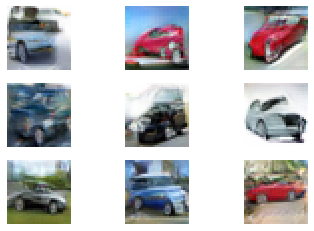

  Epoch: 92, Generator Loss: 3.206851893892655, Discriminator Loss: [0.25170705 0.        ]
  Epoch: 93, Generator Loss: 3.1611572989286523, Discriminator Loss: [0.25793806 0.        ]
  Epoch: 94, Generator Loss: 3.0736490793717213, Discriminator Loss: [0.25505954 0.        ]
  Epoch: 95, Generator Loss: 3.117468177126004, Discriminator Loss: [0.25237513 0.        ]
  Epoch: 96, Generator Loss: 3.1301864962547254, Discriminator Loss: [0.25437057 0.        ]
  Epoch: 97, Generator Loss: 3.1424729270048632, Discriminator Loss: [0.25574085 0.        ]
  Epoch: 98, Generator Loss: 3.1557832188331165, Discriminator Loss: [0.2482713 0.       ]
  Epoch: 99, Generator Loss: 3.1635716354999786, Discriminator Loss: [0.24652866 0.        ]
  Epoch: 100, Generator Loss: 3.173391514099561, Discriminator Loss: [0.24783298 0.        ]
  Epoch: 101, Generator Loss: 3.2125516128845706, Discriminator Loss: [0.24992578 0.        ]


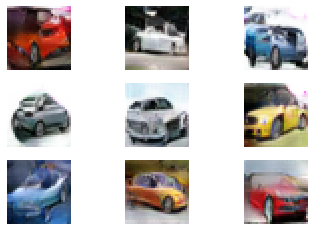

  Epoch: 102, Generator Loss: 3.1244717767605414, Discriminator Loss: [0.24971916 0.        ]
  Epoch: 103, Generator Loss: 3.169415001685803, Discriminator Loss: [0.24508797 0.        ]
  Epoch: 104, Generator Loss: 3.2164669980605445, Discriminator Loss: [0.24574447 0.        ]
  Epoch: 105, Generator Loss: 3.1016893077355165, Discriminator Loss: [0.24947572 0.        ]
  Epoch: 106, Generator Loss: 3.085572898005828, Discriminator Loss: [0.25076672 0.        ]
  Epoch: 107, Generator Loss: 3.1602788254236565, Discriminator Loss: [0.24799 0.     ]
  Epoch: 108, Generator Loss: 3.2097287204785223, Discriminator Loss: [0.24203601 0.        ]
  Epoch: 109, Generator Loss: 3.173917355445715, Discriminator Loss: [0.23916447 0.        ]
  Epoch: 110, Generator Loss: 3.182758692365426, Discriminator Loss: [0.23943588 0.        ]
  Epoch: 111, Generator Loss: 3.155044110157551, Discriminator Loss: [0.24220538 0.        ]


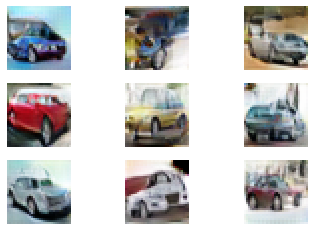

  Epoch: 112, Generator Loss: 3.1363261899886985, Discriminator Loss: [0.24274625 0.        ]
  Epoch: 113, Generator Loss: 3.166312351822853, Discriminator Loss: [0.23978908 0.        ]
  Epoch: 114, Generator Loss: 3.2091279045129433, Discriminator Loss: [0.23622642 0.        ]
  Epoch: 115, Generator Loss: 3.20852461648293, Discriminator Loss: [0.23886119 0.        ]
  Epoch: 116, Generator Loss: 3.145419410406015, Discriminator Loss: [0.24447696 0.        ]
  Epoch: 117, Generator Loss: 3.1888259771542673, Discriminator Loss: [0.24209079 0.        ]
  Epoch: 118, Generator Loss: 3.119690343355521, Discriminator Loss: [0.2405453 0.       ]
  Epoch: 119, Generator Loss: 3.125080739076321, Discriminator Loss: [0.23813815 0.        ]
  Epoch: 120, Generator Loss: 3.17504143065367, Discriminator Loss: [0.2393842 0.       ]
  Epoch: 121, Generator Loss: 3.1758141231078367, Discriminator Loss: [0.23813221 0.        ]


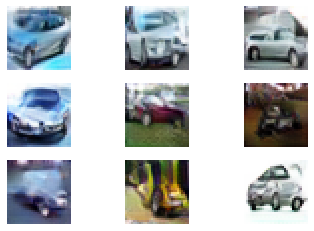

  Epoch: 122, Generator Loss: 3.238791665205589, Discriminator Loss: [0.23594178 0.        ]
  Epoch: 123, Generator Loss: 3.2200352408182926, Discriminator Loss: [0.23518234 0.        ]
  Epoch: 124, Generator Loss: 3.1959665218989053, Discriminator Loss: [0.23762321 0.        ]
  Epoch: 125, Generator Loss: 3.188743454905657, Discriminator Loss: [0.2354195 0.       ]
  Epoch: 126, Generator Loss: 3.131066299783878, Discriminator Loss: [0.23199563 0.        ]
  Epoch: 127, Generator Loss: 3.175432081788014, Discriminator Loss: [0.23504223 0.        ]
  Epoch: 128, Generator Loss: 3.2171804140775633, Discriminator Loss: [0.23452123 0.        ]
  Epoch: 129, Generator Loss: 3.244516888872171, Discriminator Loss: [0.23305768 0.        ]
  Epoch: 130, Generator Loss: 3.233184051819337, Discriminator Loss: [0.2328598 0.       ]
  Epoch: 131, Generator Loss: 3.2123830047173376, Discriminator Loss: [0.236389 0.      ]


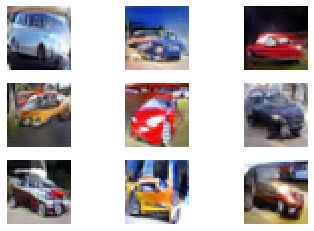

  Epoch: 132, Generator Loss: 2.9802634354967337, Discriminator Loss: [0.23697846 0.        ]
  Epoch: 133, Generator Loss: 2.745316443917079, Discriminator Loss: [0.25412712 0.        ]
  Epoch: 134, Generator Loss: 2.960672910014788, Discriminator Loss: [0.21803524 0.        ]
  Epoch: 135, Generator Loss: 2.9425481787094703, Discriminator Loss: [0.21973233 0.        ]
  Epoch: 136, Generator Loss: 3.1208904630098586, Discriminator Loss: [0.24343227 0.        ]
  Epoch: 137, Generator Loss: 3.222502895272695, Discriminator Loss: [0.23975852 0.        ]
  Epoch: 138, Generator Loss: 3.1991203335615306, Discriminator Loss: [0.2374069 0.       ]
  Epoch: 139, Generator Loss: 3.198748674148168, Discriminator Loss: [0.22589195 0.        ]
  Epoch: 140, Generator Loss: 3.2496911256741257, Discriminator Loss: [0.22865558 0.        ]
  Epoch: 141, Generator Loss: 3.1935868767591624, Discriminator Loss: [0.22789256 0.        ]


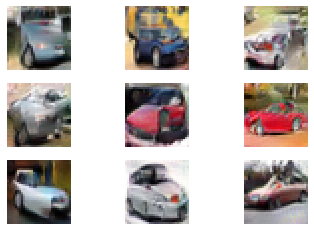

  Epoch: 142, Generator Loss: 3.1985640357702207, Discriminator Loss: [0.23301078 0.        ]
  Epoch: 143, Generator Loss: 3.1728075616634808, Discriminator Loss: [0.22898175 0.        ]
  Epoch: 144, Generator Loss: 3.1629625791922593, Discriminator Loss: [0.22846076 0.        ]
  Epoch: 145, Generator Loss: 3.238536697167617, Discriminator Loss: [0.22889733 0.        ]
  Epoch: 146, Generator Loss: 3.180219231889798, Discriminator Loss: [0.23122413 0.        ]
  Epoch: 147, Generator Loss: 3.1823841696366286, Discriminator Loss: [0.23061936 0.        ]
  Epoch: 148, Generator Loss: 3.217523788794493, Discriminator Loss: [0.23010464 0.        ]
  Epoch: 149, Generator Loss: 3.155673924546975, Discriminator Loss: [0.22568168 0.        ]
  Epoch: 150, Generator Loss: 3.152856041987737, Discriminator Loss: [0.22629146 0.        ]
  Epoch: 151, Generator Loss: 3.180669977114751, Discriminator Loss: [0.22754608 0.        ]


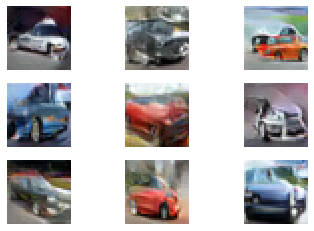

  Epoch: 152, Generator Loss: 3.1802612099892054, Discriminator Loss: [0.22725697 0.        ]
  Epoch: 153, Generator Loss: 3.2239208164123387, Discriminator Loss: [0.22749864 0.        ]
  Epoch: 154, Generator Loss: 3.199472339871602, Discriminator Loss: [0.22526881 0.        ]
  Epoch: 155, Generator Loss: 3.2207517627722178, Discriminator Loss: [0.22387551 0.        ]
  Epoch: 156, Generator Loss: 3.1334209319872732, Discriminator Loss: [0.22508176 0.        ]
  Epoch: 157, Generator Loss: 3.193999631282611, Discriminator Loss: [0.22627746 0.        ]
  Epoch: 158, Generator Loss: 3.1504543255536985, Discriminator Loss: [0.22527856 0.        ]
  Epoch: 159, Generator Loss: 3.1954533595305223, Discriminator Loss: [0.22708191 0.        ]
  Epoch: 160, Generator Loss: 3.1586621399873342, Discriminator Loss: [0.22465904 0.        ]
  Epoch: 161, Generator Loss: 3.1905829360087714, Discriminator Loss: [0.22369783 0.        ]


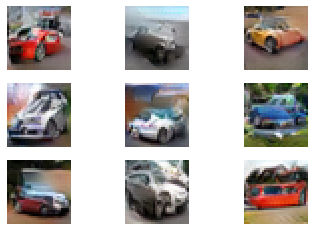

  Epoch: 162, Generator Loss: 3.166593845073993, Discriminator Loss: [0.22103436 0.        ]
  Epoch: 163, Generator Loss: 3.1111975736342945, Discriminator Loss: [0.2215395 0.       ]
  Epoch: 164, Generator Loss: 3.1776561118089237, Discriminator Loss: [0.22561455 0.        ]
  Epoch: 165, Generator Loss: 3.0952345606608267, Discriminator Loss: [0.22418475 0.        ]
  Epoch: 166, Generator Loss: 3.081246247276282, Discriminator Loss: [0.22137877 0.        ]
  Epoch: 167, Generator Loss: 3.140052709824, Discriminator Loss: [0.2215173 0.       ]
  Epoch: 168, Generator Loss: 3.0582657200403705, Discriminator Loss: [0.22181046 0.        ]
  Epoch: 169, Generator Loss: 3.1481624986880865, Discriminator Loss: [0.22276245 0.        ]
  Epoch: 170, Generator Loss: 3.112536604205767, Discriminator Loss: [0.22320464 0.        ]
  Epoch: 171, Generator Loss: 3.139525884619126, Discriminator Loss: [0.22057506 0.        ]


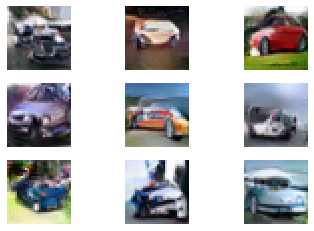

  Epoch: 172, Generator Loss: 3.050417261245923, Discriminator Loss: [0.22062749 0.        ]
  Epoch: 173, Generator Loss: 3.1314546576677222, Discriminator Loss: [0.2228838 0.       ]
  Epoch: 174, Generator Loss: 3.0827041073487353, Discriminator Loss: [0.22506389 0.        ]
  Epoch: 175, Generator Loss: 3.057351536475695, Discriminator Loss: [0.22421983 0.        ]
  Epoch: 176, Generator Loss: 3.116927431179927, Discriminator Loss: [0.21913125 0.        ]
  Epoch: 177, Generator Loss: 3.162336039237487, Discriminator Loss: [0.21924102 0.        ]
  Epoch: 178, Generator Loss: 3.0624151054101114, Discriminator Loss: [0.2214725 0.       ]
  Epoch: 179, Generator Loss: 3.1058429235067124, Discriminator Loss: [0.21877949 0.        ]
  Epoch: 180, Generator Loss: 3.099214282937539, Discriminator Loss: [0.2200288 0.       ]
  Epoch: 181, Generator Loss: 3.115386051627306, Discriminator Loss: [0.22157063 0.        ]


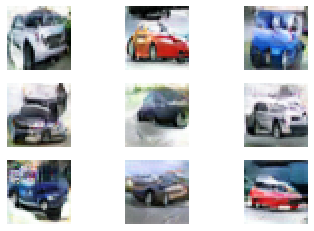

  Epoch: 182, Generator Loss: 3.12774467200805, Discriminator Loss: [0.21853615 0.        ]
  Epoch: 183, Generator Loss: 3.115045604033348, Discriminator Loss: [0.22177342 0.        ]
  Epoch: 184, Generator Loss: 3.144699547535334, Discriminator Loss: [0.22397335 0.        ]
  Epoch: 185, Generator Loss: 3.1881699760754905, Discriminator Loss: [0.22017398 0.        ]
  Epoch: 186, Generator Loss: 3.1729853737812777, Discriminator Loss: [0.21985705 0.        ]
  Epoch: 187, Generator Loss: 3.087201248376797, Discriminator Loss: [0.21938491 0.        ]
  Epoch: 188, Generator Loss: 3.084798963788228, Discriminator Loss: [0.21863948 0.        ]
  Epoch: 189, Generator Loss: 3.1200439849725137, Discriminator Loss: [0.21944608 0.        ]
  Epoch: 190, Generator Loss: 3.096486719755026, Discriminator Loss: [0.22113572 0.        ]
  Epoch: 191, Generator Loss: 3.1017693957457175, Discriminator Loss: [0.2187781 0.       ]


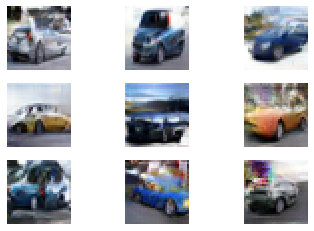

  Epoch: 192, Generator Loss: 3.0767941234203486, Discriminator Loss: [0.21801727 0.        ]
  Epoch: 193, Generator Loss: 3.0995424741353745, Discriminator Loss: [0.21954316 0.        ]
  Epoch: 194, Generator Loss: 3.070795062642831, Discriminator Loss: [0.220854 0.      ]
  Epoch: 195, Generator Loss: 3.079974727752881, Discriminator Loss: [0.21823697 0.        ]
  Epoch: 196, Generator Loss: 2.988577207693687, Discriminator Loss: [0.21786492 0.        ]
  Epoch: 197, Generator Loss: 3.1119106133014727, Discriminator Loss: [0.21661526 0.        ]
  Epoch: 198, Generator Loss: 3.0875644783178964, Discriminator Loss: [0.21821785 0.        ]
  Epoch: 199, Generator Loss: 3.141568280183352, Discriminator Loss: [0.21726249 0.        ]
  Epoch: 200, Generator Loss: 3.1390322874753904, Discriminator Loss: [0.21677811 0.        ]


In [9]:
N_EPOCHS = 200
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  if epoch%10==0:
    show_imgs("epoch" + str(epoch))

In [0]:
path = "./cifar_1LD12k"
num_examples = 15000
noise = generate_noise(num_examples, 100)
gen_imgs = generator.predict(noise)

for i in range(num_examples):
  img = image.array_to_img(gen_imgs[i], scale=True)
  img.save(path+"/image"+str(i)+".png", "PNG")


In [16]:
!ls -l /content/sample2/cifar_1LD12k/

total 60000
-rw-r--r-- 1 root root 2622 Dec 13 23:14 image0.png
-rw-r--r-- 1 root root 2624 Dec 13 23:14 image10000.png
-rw-r--r-- 1 root root 2626 Dec 13 23:14 image10001.png
-rw-r--r-- 1 root root 2659 Dec 13 23:14 image10002.png
-rw-r--r-- 1 root root 2617 Dec 13 23:14 image10003.png
-rw-r--r-- 1 root root 2437 Dec 13 23:14 image10004.png
-rw-r--r-- 1 root root 2766 Dec 13 23:14 image10005.png
-rw-r--r-- 1 root root 2392 Dec 13 23:14 image10006.png
-rw-r--r-- 1 root root 2602 Dec 13 23:14 image10007.png
-rw-r--r-- 1 root root 2413 Dec 13 23:14 image10008.png
-rw-r--r-- 1 root root 2390 Dec 13 23:14 image10009.png
-rw-r--r-- 1 root root 2648 Dec 13 23:14 image1000.png
-rw-r--r-- 1 root root 2545 Dec 13 23:14 image10010.png
-rw-r--r-- 1 root root 2522 Dec 13 23:14 image10011.png
-rw-r--r-- 1 root root 2620 Dec 13 23:14 image10012.png
-rw-r--r-- 1 root root 2715 Dec 13 23:14 image10013.png
-rw-r--r-- 1 root root 2525 Dec 13 23:14 image10014.png
-rw-r--r-- 1 root root 2373 Dec 13 23:14 

In [0]:
!rmdir /content/sample2/cifar_1LD12k/

In [28]:
#Importing the required libraries 
%matplotlib inline
import numpy  as np  
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
import h5py
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from keras.datasets import mnist, fashion_mnist, cifar10

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint, Callback

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model

from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Reshape, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, MaxPool2D, Convolution2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical,normalize

from keras import optimizers
from keras.optimizers import SGD, RMSprop, Adam, Nadam

import pickle
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
def log_mean_exp(t):
    # prevent overflow
    # \sum{i=1}^n e^{x_i} = e^\max{x_j} \sum{i=1}^n e^{x_i-\max{x_j}}
    max_ = t.max(1, keepdims=True)
    return np.squeeze(max_) + np.log(np.mean(np.exp(t - max_), 1)) # log-likelihood


def parzen_batch(x, mu, sigma):
    '''
        x: [batch_size, z_dim]
        mu: [n, z_dim]
        sigma: float scalar
    '''

    x = np.expand_dims(x, axis=1)
    mu = np.expand_dims(mu, axis=0)
    t = (((x - mu) / sigma)**2).sum(2)*(-0.5)
    E = log_mean_exp(t)
    Z = mu.shape[2] * np.log(sigma*np.sqrt(2*np.pi))
    return E - Z


def get_lls(x, mu, sigma, batch_size=10):
    lls = np.array([])
    num_samples = x.shape[0]
    num_batches = (num_samples+batch_size-1)//batch_size
    for i in range(num_batches):
        ll = parzen_batch(x[(i*batch_size):min((i+1)*batch_size, num_samples)], mu, sigma)
        lls = np.append(lls, ll)
    return lls


def cross_validate_sigma(x, mu, sigmas, batch_size=10):
    '''
        x: validation data
        mu: generative data
        sigmas: sigma sequence
    '''
    lls = []
    for sigma in sigmas:
        ll = get_lls(x, mu, sigma, batch_size=batch_size)
        lls.append(ll.mean())
        print('Sigma: {}, LL: {}'.format(sigma, ll.mean()))
    return sigmas[np.argmax(lls)]
    


    
def main_run(gen_data_path, limit_size = 100, batch_size = 50, cross_val = 10, sigma_start = -1, sigma_end = 0., file = "gan_mnist.txt"):
#    parser = argparse.ArgumentParser(description = 'Gaussian parzen window, negative log-likelihood estimator.')
#    parser.add_argument('-d', '--data_dir', default='/home/clb/dataset/mnist',  help='Directory to load mnist.')
#    parser.add_argument('-g', '--gen_data_path', default='result/scgan_mnist/scgan_mnist.npy', help='Path to load generative data.')
#    parser.add_argument('-l', '--limit_size', default=1000, type=int, help='The number of samples in validation.')
#    parser.add_argument('-b', '--batch_size', default=100, type=int)
#    parser.add_argument('-c', '--cross_val', default=10, type=int,
#                            help="Number of cross valiation folds")
#    parser.add_argument('--sigma_start', default=-1, type=float)
#    parser.add_argument('--sigma_end', default=0., type=float)
#    parser.add_argument('--file', default='cgan_mnist.txt', help='File to save mean and std of log-likelihood.')
#    args = parser.parse_args()

    # load mnist
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    trainX = trainX.reshape([-1, 1024]).astype(np.float32)/255.
    testX = testX.reshape([-1, 1024]).astype(np.float32)/255.

    x = trainX[-limit_size:]
    filenames = []
    for ids, filename in enumerate(glob.glob(gen_data_path)):
      filenames += [cv2.imread(filename,0)]
      if ids%1000 == 0:
        print(ids)
    mu = np.array(filenames).reshape([-1, 1024]).astype(np.float32)/255.
    print(mu.shape)
    print(x.shape)
    #raise Exception("stop")
    #mu = np.load(gen_data_path).astype(np.float32)/255.

    sigmas = np.logspace(sigma_start, sigma_end, cross_val)
    sigma = cross_validate_sigma(x, mu, sigmas, batch_size)
    print('Using Sigma: {}'.format(sigma))
    lls = get_lls(testX, mu, sigma, batch_size)
    print('Negative Log-Likelihood of Test Set = {}, Std: {}'.format(lls.mean(), lls.std()/np.sqrt(testX.shape[0])))
    #with open(file, 'w') as f:
    #    f.write('Negative Log-Likelihood of Test Set = {}, Std: {}\n'.format(lls.mean(), lls.std()/np.sqrt(testX.shape[0]))) 


In [22]:
main_run(gen_data_path = "/content/sample2/cifar_1LD12k/*.png")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
(15000, 1024)
(100, 1024)
Sigma: 0.1, LL: -1093.064210205078
Sigma: 0.1291549665014884, LL: -353.629130859375
Sigma: 0.16681005372000587, LL: -15.271498413085938
Sigma: 0.21544346900318834, LL: 82.6519613647461
Sigma: 0.2782559402207124, LL: 36.44733001708985
Sigma: 0.35938136638046275, LL: -96.1458967590332
Sigma: 0.46415888336127786, LL: -280.5006759643555
Sigma: 0.5994842503189409, LL: -495.83393341064453
Sigma: 0.774263682681127, LL: -729.6291656494141
Sigma: 1.0, LL: -974.2834033203125
Using Sigma: 0.21544346900318834
Negative Log-Likelihood of Test Set = 114.08320045166016, Std: 1.3584376338705686
